In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
NY_311_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/New_York_NY_311.csv'
NY_BUILDING_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/New_York_NY_Building_Permits.csv'
AUSTIN_311_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Austin_TX_311.csv'
DC_311_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Washington_DC_311_2021_2022.csv'
NY_BUSI_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/New_York_NY_Operating_Business_Licenses.csv'
AUSTIN_BUSI_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Austin_TX_Operating_Business_Licenses.csv'
DC_BUILDING_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Washington_DC_Building_Permits_2021_2022.csv'
DC_BUSI_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Washington_DC_Operating_Business_Licenses.csv'
AUSTIN_BUILDING_FILE = 'drive/MyDrive/Final_City_Comparison_Datasets/Austin_TX_Building_Permits.csv'

In [ ]:

def conflate_nyc(s):
    s = s.lower()
    if s in ['noise - helicopter',
    'noise - street/sidewalk',
    'noise - vehicle',
    'collection truck noise']:
        return 'noise traffic'
    if "noise" in s:
        return "noise"
    if s in ['water leak', 'water conservation']:
        return 'water system'
    if s=='bottled water':
        return 'drinking water'
    if 'highway sign' in s:
        return 'highway sign'
    if s in ['snw', 'snow or ice']:
        return 'snow'
    if s =='dep highway condition':
        return 'highway condition'
    if 'for hire vehicle' in s:
        return 'for hire vehicle'
    if s =='covid-19 non-essential construction' or s == 'face covering violation':
        return 'covid'
    return s

def conflate_dc(s):
    s = s.lower()
    if 'parking permit' in s:
        return 'parking permit'
    if 'yard waste' in s:
        return 'yard waste'
    if 'abandoned vehicle' in s:
      return 'abandoned vehicle'
    if 'dmv - drivers license/id':
        return 'dmv - drivers license/id'
    if 'recycling cart' in s:
        return 'recycling cart'
    if 'trash cart' in s:
        return 'trash cart'
    if 'covid' in s:
        return 'covid'
    return s

def conflate_austin(s):
    s = s.lower()
    if 'traffic signal' in s:
        return 'Traffic Signal'
    if 'sign -' in s:
        return 'sign'
    if 'flood' in s:
        return 'Flood'
    if 'park maintenance - ground' in s:
        return 'park Maintenance - ground'
    if 'park maintenance - building' in s:
        return 'park maintenance - building'
    if 'park maintenance' in s:
        return 'park maintenance'
    if 'covid' in s:
        return 'covid'
    return s


In [ ]:
austin_types = ['austin code - request code officer',
 'Traffic Signal',
 'loose dog',
 'arr missed recycling',
 'animal control - assistance request',
 'arr dead animal collection',
 'street light issue- address',
 'injured / sick animal',
 'sign',
 'arr missed yard trimmings/compost',
 'park Maintenance - ground',
 'pothole repair',
 'loud commercial music',
 'code compliance',
 'debris in street',
 'tree issue row',
 'water waste report',
 'public health - graffiti abatement',
 'arr brush and bulk',
 'arr missed yard trimmings /organics',
 'animal - proper care',
 'parking violation enforcement',
 'graffiti abatement',
 'covid']

nyc_types = ['noise',
 'noise traffic',\
 'illegal parking',
 'heat/hot water',
 'blocked driveway',
 'water system',
 'street condition',
 'unsanitary condition',
 'street light condition',
 'non-emergency police matter',
 'damaged tree',
 'abandoned vehicle',
 'plumbing',
 'derelict vehicles',
 'missed collection (all materials)',
 'general construction/plumbing',
 'traffic signal condition',
 'rodent',
 'illegal fireworks',
 'paint/plaster',
 'noncompliance with phased reopening',
 'sewer',
 'homeless person assistance',
 'dirty conditions',
 'covid']

dc_types = ['bulk collection',
 'parking enforcement',
 'trash collection - missed',
 'abandoned vehicle',
 'illegal dumping',
 'parking meter repair',
 'rodent inspection and treatment',
 'dc government information',
 'streetlight repair investigation',
 'parking permit',
 'yard waste',
 'roadway signs',
 'sanitation enforcement',
 'recycling collection - missed',
 'tree inspection',
 'out of state parking violation (rosa)',
 'graffiti removal',
 'alley cleaning',
 'sidewalk repair',
 'dmv - drivers license/id',
 'trash cart',
 'recycling cart',
 'traffic signal issue',
 'street cleaning',
 'covid']


In [ ]:
## Columns we care about now: 
##    'complaint_type', 'description', 'agency', 'create_time', 'close_time',  'create_ordinal', 'due_time', 'status', 'ward', 'channel'


def preprocess_dc(df):

  ## clean invalid rows:
  df = df.loc[(df.CITY == 'WASHINGTON') & (df.STATE == 'DC') & (df['SERVICECODEDESC'] != 'Test') &  (df['SERVICECODEDESC'] != 'Sample SR')] 

  ## drop none that shouldn't be nan
  df = df.dropna(subset=['SERVICECODEDESC', 'SERVICETYPECODEDESC', 'ORGANIZATIONACRONYM', 'ADDDATE', 'SERVICEDUEDATE', 'SERVICEORDERSTATUS'])
  
  ## datatime string to datetime
  df['create_time'] = pd.to_datetime(df['ADDDATE'], infer_datetime_format=True)
  df['close_time'] = pd.to_datetime(df['RESOLUTIONDATE'], infer_datetime_format=True)
  df['due_time'] = pd.to_datetime(df['SERVICEDUEDATE'], infer_datetime_format=True)
  df['create_ordinal'] =df['create_time'].apply(datetime.datetime.toordinal) 
  # df['close_ordinal'] =[x.toordinal() for x in df['close_time']]

  ## keep name consistant
  df = df.rename(columns={'SERVICECODEDESC': 'complaint_type',
                          'SERVICETYPECODEDESC': 'description', 
                          'ORGANIZATIONACRONYM': 'agency',
                          'SERVICEORDERSTATUS': 'status',
                          'WARD': 'ward'})
  
  df['complaint_type'] = df['complaint_type'].apply(conflate_dc)
  df = df[df.complaint_type.isin(dc_types)]

  ## filter out irrelevant columns
  df = df[['complaint_type', 'description', 'agency', 'create_time', 'close_time', 'create_ordinal', 'due_time', 'status', 'ward']]
  
  return df


def preprocess_nyc(df):

  ## TODO: clean invalid rows


  ## drop none that shouldn't be nan
  df = df.dropna(subset=['Unique Key', 'Created Date', 'Agency', 'Complaint Type'])
  
  ## datatime string to datetime
  df['create_time'] = pd.to_datetime(df['Created Date'], format='%m/%d/%Y %H:%M:%S %p')
  df['close_time'] = pd.to_datetime(df['Closed Date'], format='%m/%d/%Y %H:%M:%S %p')
  df['due_time'] = pd.to_datetime(df['Due Date'], format='%m/%d/%Y %H:%M:%S %p')
  df['create_ordinal'] = df['create_time'].apply(datetime.datetime.toordinal) 
  # df['close_ordinal'] =[x.toordinal() for x in df['close_time']]

  ## keep name consistant
  df = df.rename(columns={'Complaint Type': 'complaint_type',
                          'Descriptor': 'description', 
                          'Agency': 'agency',
                          'Status': 'status',
                          'Park Borough': 'ward',
                          'Open Data Channel Type': 'channel'})
  df['complaint_type'] = df['complaint_type'].apply(conflate_nyc)
  df = df[df.complaint_type.isin(nyc_types)]

  ## filter out irrelevant columns
  df = df[['complaint_type', 'description', 'agency', 'create_time', 'close_time',  'create_ordinal', 'due_time', 'status', 'ward', 'channel']]
  return df


def preprocess_austin(df):

  ##  clean invalid rows
  df = df.loc[df.City == 'AUSTIN']

  ## drop none that shouldn't be nan
  df = df.dropna(subset=['Service Request (SR) Number', 'Created Date', 'SR Description', 'SR Status'])
  
  ## datatime string to datetime
  df['create_time'] = pd.to_datetime(df['Created Date'],  format='%m/%d/%Y %H:%M:%S %p')
  df['close_time'] = pd.to_datetime(df['Close Date'],  format='%m/%d/%Y %H:%M:%S %p')
  df['create_ordinal'] = df['create_time'].apply(datetime.datetime.toordinal) 
  # df['close_ordinal'] =[x.toordinal() for x in df['close_time']]

  ## keep name consistant
  df = df.rename(columns={'SR Description': 'complaint_type', 
                          'Agency': 'agency',
                          'SR Status': 'status',
                          'County': 'ward',
                          'Method Received': 'channel'})
  df['complaint_type'] = df['complaint_type'].apply(conflate_austin)
  df = df[df.complaint_type.isin(austin_types)]
  
  ## TODO: conflate Austin SR discription into categories

  ## filter out irrelevant columns
  df = df[['complaint_type', 'create_time', 'close_time', 'create_ordinal','status', 'ward', 'channel']]
  return df

  


In [ ]:
dc_311 = pd.read_csv(DC_311_FILE, low_memory=False)
df_dc = preprocess_dc(dc_311)
df_dc.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/DC_311_clean.csv')

In [ ]:
nyc_311 = pd.read_csv(NY_311_FILE)
df_nyc = preprocess_nyc(nyc_311)
df_nyc.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/NYC_311_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,18,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
austin_311 = pd.read_csv(AUSTIN_311_FILE)
df_austin = preprocess_austin(austin_311)
df_austin.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/Austin_311_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Before this cell is data cleaning

### After this cell: visualization

In [ ]:
ny_all = 'drive/MyDrive/datathon/Copy of NYC_311_clean.csv'
df_nyc = pd.read_csv(ny_all)

In [ ]:
df_nyc['day_till_fix'] = (df_nyc.close_time - df_nyc.create_time).dt.days
df_nyc = df_nyc[df_nyc['day_till_fix'] >= 0]
df_nyc['create_day'] = df_nyc['create_ordinal'].apply(lambda a: datetime.datetime.fromordinal(int(a)))
nyc_311_feat = df_nyc.groupby('create_day').agg({'day_till_fix': 'mean', 'complaint_type': 'count' }).rename(columns={
    'day_till_fix':'average_day_till_fix',
    'complaint_type': 'count'
})

In [ ]:
df_dc['day_till_fix'] = (df_dc.close_time - df_dc.create_time).dt.days
df_dc['create_day'] = df_dc['create_ordinal'].apply(lambda a: datetime.datetime.fromordinal(int(a)))
dc_311_feat = df_dc.groupby('create_day').agg({'day_till_fix': 'mean', 'complaint_type': 'count' }).rename(columns={
    'day_till_fix':'average_day_till_fix',
    'complaint_type': 'count'
})

In [ ]:
datetime.datetime.toordinal(datetime.datetime(2020, 1,1))

737425

In [ ]:
df_austin = df_austin[df_austin.create_ordinal>=737425]
df_austin['day_till_fix'] = (df_austin.close_time - df_austin.create_time).dt.days
df_austin['create_day'] = df_austin['create_ordinal'].apply(lambda a: datetime.datetime.fromordinal(int(a)))
austin_311_feat = df_austin.groupby('create_day').agg({'day_till_fix': 'mean', 'complaint_type': 'count' }).rename(columns={
    'day_till_fix':'average_day_till_fix',
    'complaint_type': 'count'
})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


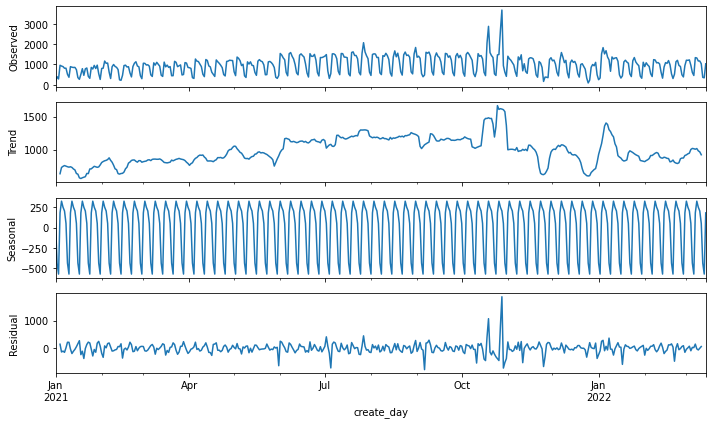

In [ ]:
result=seasonal_decompose(dc_311_feat['count'], model='additive')
fig = result.plot()
fig.set_size_inches((10, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

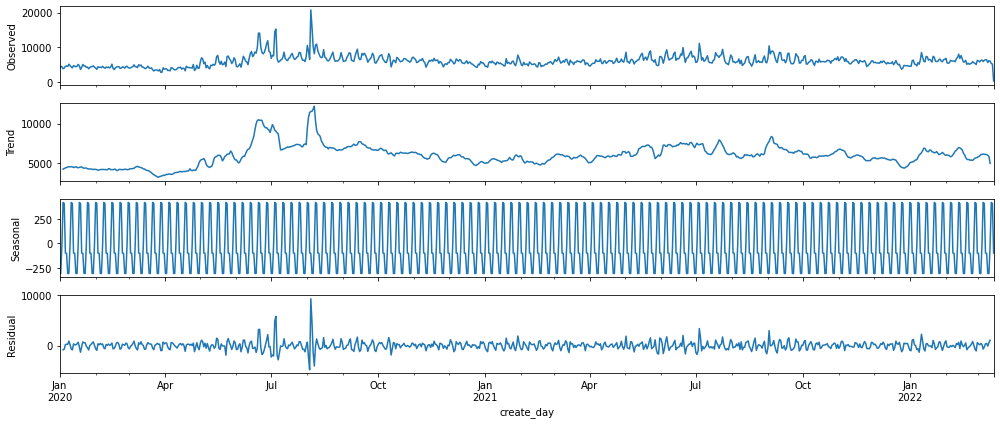

In [ ]:
result_nyc = seasonal_decompose(nyc_311_feat['count'], model='additive')
fig = result_nyc.plot()
fig.set_size_inches((14, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
austin_311_feat.head()

,average_day_till_fix,count
create_day,,
2014-01-01,327.800000,30
2014-01-02,33.890323,155
2014-01-03,25.937500,288
2014-01-04,16.068493,146
2014-01-05,3.152941,85


In [ ]:
austin_311_feat.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-12',
               '2022-03-13', '2022-03-14'],
              dtype='datetime64[ns]', name='create_day', length=2993, freq=None)

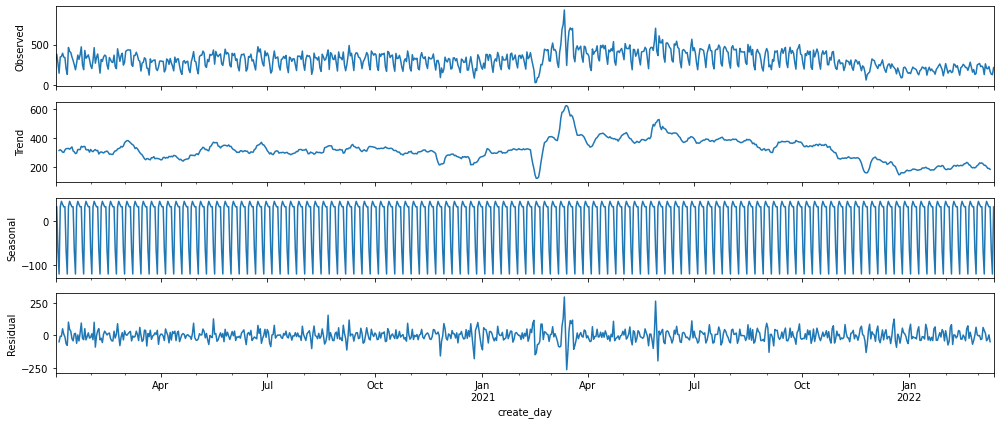

In [ ]:
result_austin = seasonal_decompose(austin_311_feat['count'], model='additive', freq=7)
fig = result_austin.plot()
fig.set_size_inches((14, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
COVID_DC_FILE = '/content/drive/MyDrive/Final_City_Comparison_Datasets/DC_COVID-19_Cases_by_Ward.csv'
COVID_NYC_FILE = '/content/drive/MyDrive/covid_data/COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv'
CRIME_DC = '/content/drive/MyDrive/crime data/DC/DC Crime Incidents 2021.csv'
CRIME_NYC_20 = '/content/drive/MyDrive/crime data/NYC/NYPD Calls for Service 2020.csv'
CRIME_NYC_21 = '/content/drive/MyDrive/crime data/NYC/NYPD Calls for Service 2021.csv'

In [ ]:
df_dc_covid = pd.read_csv(COVID_DC_FILE)
df_dc_covid['datetime'] = pd.to_datetime(df_dc_covid['REPORT_DATE'], infer_datetime_format=True)
df_dc_covid['day'] = df_dc_covid['datetime'].dt.date
df_dc_covid_byday = df_dc_covid.groupby(by='day').sum()[['LIVES_LOST', 'POSITIVE_CASES']]
df_dc_covid_byday['311_volume'] = dc_311_feat['count']
df_dc_covid_byday['311_day_till_fix'] = dc_311_feat['average_day_till_fix']
df_dc_311_covid = df_dc_covid_byday.dropna()
df_dc_311_covid['311_seasonal'] = result.seasonal
df_dc_311_covid['trend'] = result.trend
df_dc_311_covid['weekday'] = pd.to_datetime(df_dc_311_covid.index.to_series()).dt.day_name()
df_crime_dc = pd.read_csv(CRIME_DC)
df_crime_dc['day'] =  pd.to_datetime(df_crime_dc['START_DATE'],  infer_datetime_format=True).dt.date
df_crime_dc['weekday'] =  pd.to_datetime(df_crime_dc['START_DATE'],  infer_datetime_format=True).dt.day_name()
df_dc_311_covid = df_dc_311_covid.fillna(method='bfill')
df_dc_311_covid['crime_count'] = df_crime_dc['day'].value_counts()
feature_dc = df_dc_311_covid.fillna(0)

feature_dc.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/feature_dc.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
df_nyc_covid = pd.read_csv(COVID_NYC_FILE)
df_nyc_covid['datetime'] = pd.to_datetime(df_nyc_covid['DATE_OF_INTEREST'], infer_datetime_format=True)
df_nyc_covid['day'] = df_nyc_covid['datetime'].dt.date
df_nyc_covid_byday = df_nyc_covid.groupby(by='day').sum()[['CASE_COUNT', 'DEATH_COUNT']].dropna()
df_nyc_covid_byday['311_volume'] = nyc_311_feat['count']
df_nyc_covid_byday['311_day_till_fix'] = nyc_311_feat['average_day_till_fix']
df_nyc_311_covid = df_nyc_covid_byday.dropna()
df_nyc_311_covid['311_seasonal'] = result_nyc.seasonal
df_nyc_311_covid['trend'] = result_nyc.trend
df_nyc_311_covid['weekday'] = pd.to_datetime(df_nyc_311_covid.index.to_series()).dt.day_name()
feature_nyc = df_nyc_311_covid.fillna(method='bfill')

feature_nyc.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/feature_nyc.csv')

NameError: ignored

In [ ]:
feature_nyc = pd.read_csv('drive/MyDrive/Final_City_Comparison_Datasets/feature_nyc.csv', index_col='day')

In [ ]:
feat = feature_dc.reset_index()
feat['day'] = pd.to_datetime(feat['day'])
feat_dc_full = pd.merge(df_dc, feat, left_on='create_day', right_on='day').drop(columns=['description', 'create_time', 'due_time', 'close_time', 'status', 'create_day'])
feat_dc_full.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/dc_full_clean.csv')

NameError: ignored

In [ ]:
feat_nyc = feature_nyc.reset_index()
feat_nyc['day'] = pd.to_datetime(feat_nyc['day'])
feat_nyc_full = pd.merge(df_nyc, feat_nyc, left_on='create_day', right_on='day').drop(columns=['description', 'create_time', 'due_time', 'close_time', 'status', 'create_day'])
feat_nyc_full.to_csv('drive/MyDrive/Final_City_Comparison_Datasets/nyc_full_clean.csv')

In [ ]:
feat_nyc_full.shape

(4549209, 15)